In [ ]:
import pandas as pd
import numpy as np
import pylab as plt
from sklearn import metrics
from sklearn import cluster
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn import pipeline 
from sklearn.compose import ColumnTransformer
from datetime import datetime as dt , time , date
import datetime
import seaborn as sns
from dateutil.parser import parse
import scipy.stats as stats
from sklearn.cluster import KMeans , MiniBatchKMeans

import lightgbm as lgb
%matplotlib inline

SEED = 70

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!unzip -P trrfd "./drive/My Drive/UmojaHackYassir.zip"

Archive:  ./drive/My Drive/UmojaHackYassir.zip
   creating: UmojaHack25July/
  inflating: UmojaHack25July/Test.csv  
  inflating: UmojaHack25July/Weather.csv  
  inflating: UmojaHack25July/Train.csv  
  inflating: UmojaHack25July/SampleSubmission.csv  


In [ ]:
# load training
training = pd.read_csv('UmojaHack25July/Train.csv').set_index('ID')
training['Timestamp'] = pd.to_datetime(training['Timestamp'])
# testing data
testing = pd.read_csv('UmojaHack25July/Test.csv').set_index('ID')
testing['Timestamp'] = pd.to_datetime(testing['Timestamp'])
# weather data
weather_df = pd.read_csv('UmojaHack25July/Weather.csv')
weather_df['date'] = pd.to_datetime(weather_df['date'])



# Adding datetime features

In [ ]:
def add_date_features(df,timestamp_id):

    df.loc[:, 'pickup_weekday'] = df[timestamp_id].dt.weekday
    df.loc[:, 'pickup_hour_weekofyear'] = df[timestamp_id].dt.weekofyear
    df.loc[:, 'pickup_hour'] = df[timestamp_id].dt.hour
    df.loc[:, 'pickup_minute'] = df[timestamp_id].dt.minute
    df.loc[:, 'pickup_dt'] = (df[timestamp_id] - df[timestamp_id].min()).dt.total_seconds()
    df.loc[:, 'pickup_week_hour'] = df['pickup_weekday'] * 24 + df['pickup_hour']
    def get_season(now):
        Y=2000
        seasons = [(1, (date(Y,  1,  1),  date(Y,  3, 20))),
                (2, (date(Y,  3, 21),  date(Y,  6, 20))),
                (3, (date(Y,  6, 21),  date(Y,  9, 22))),
                (4, (date(Y,  9, 23),  date(Y, 12, 20))),
                (1, (date(Y, 12, 21),  date(Y, 12, 31)))]

        if isinstance(now, datetime.datetime):
            now = now.date()
        now = now.replace(year=Y)
        return next(season for season, (start, end) in seasons
                    if start <= now <= end)
    
    
    df['day_of_week']=df[timestamp_id].dt.dayofweek
    df['day_of_week']= df['day_of_week'].astype('category') 

    df['is_month_end']=df[timestamp_id].dt.is_month_end  
    df['is_month_end']= df['is_month_end'].astype('category')
    df['is_month_start']=df[timestamp_id].dt.is_month_start
    df['is_month_start']= df['is_month_start'].astype('category')
    df['day_of_year']=df[timestamp_id].dt.dayofyear
    df['day_of_year']= df['day_of_year'].astype('category')

    df['is_quarter_end']=df[timestamp_id].dt.is_quarter_end
    df['is_quarter_end']= df['is_quarter_end'].astype('category')
    df['is_quarter_start']=df[timestamp_id].dt.is_quarter_start
    df['is_quarter_start']= df['is_quarter_start'].astype('category')
    df['season']=df[timestamp_id].apply(get_season)    
    df['season']= df['season'].astype('category')

In [ ]:
#mergin test and train data to process them together (adding features ...etc)
testing['test']=True
training['test']=False

data=training.append(testing)

#adding date features
add_date_features(data,'Timestamp')

# Cleaning eta and distance 

the dataset contained some anomalies that needed to be removed , this code summarizes the steps token to clean it

In [ ]:
#creating speed feature to clean our dataset
data["speed"]=data.apply(lambda x : (x["Trip_distance"] / x['ETA'] )* (3.6) if x['test']==False else None,axis="columns")  

In [ ]:
#dropping anomalies in the train data (which is why i added 'data.test==False' condition)

filter  = (data.test==False) & ( (data.ETA<10 )  |  (data.speed>120)  | ( data.Trip_distance<1 | ( (data.Trip_distance<1 )  & (data.ETA < 60) )   ) )


cleaned = data.drop(data[filter].index)



# Clustering and gps processing

in order to add more context to our gps coordinates I produced two kind of clustering; trip clustering and pickup , dropoff clustering  

In [ ]:
#trip clustering
 
kmean=KMeans(n_clusters=10,random_state=SEED)

coords = cleaned[['Origin_lat'	,'Origin_lon'	,'Destination_lat'	,'Destination_lon']]

cleaned["cluster_id"]=kmean.fit_predict(coords)
cleaned["cluster_id"]=cleaned["cluster_id"].astype('category')

In [ ]:
#pickup and dropoff clustering separately 
minikmean=MiniBatchKMeans(n_clusters=12,batch_size=1000,random_state=SEED)

cl_pickup = minikmean.fit_predict(cleaned[['Origin_lat'	,'Origin_lon']])
cl_dropoff = minikmean.fit_predict(cleaned[['Destination_lat'	,'Destination_lon']])

cleaned["cluster_Dest"] = cl_dropoff
cleaned["cluster_Orig"] = cl_pickup

cleaned["cluster_Dest"]=cleaned["cluster_Dest"].astype('category')
cleaned["cluster_Orig"]=cleaned["cluster_Orig"].astype('category')

# PCA for gps coordinates

here i tried to apply pca to see the impact on the predictive model ,I was inspired by this [kernel](https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367)

In [ ]:
from sklearn.decomposition import PCA
coords =np.vstack((cleaned[['Origin_lat'	,'Origin_lon']], 
                        cleaned[['Destination_lat'	,'Destination_lon']])) 

pca = PCA(random_state=SEED).fit(coords) # define 2 main axis


cleaned['Origin_pca0'] = pca.transform(cleaned[['Origin_lon', 'Origin_lat']])[:,0]
cleaned['Origin_pca1'] = pca.transform(cleaned[['Origin_lon', 'Origin_lat']])[:,1]
cleaned['Destination_pca0'] = pca.transform(cleaned[['Destination_lon', 'Destination_lat']])[:,0]
cleaned['Destination_pca1'] = pca.transform(cleaned[['Destination_lon', 'Destination_lat']])[:,1]
cleaned['distance_pca0'] = np.abs(cleaned.Origin_pca0-cleaned.Destination_pca0)
cleaned['distance_pca1'] = np.abs(cleaned.Origin_pca1-cleaned.Destination_pca1)

# Adding weather

first we need to fill missing values for December 31th 2019 , we will need it later in the test set since it contains trips on that date 

In [ ]:
#I opted for the simplest solution by simply imputing missing values by averaging values from the previous 2 months
res=weather_df.mean()

res["date"]=parse("2019-12-31")

# add the new row to our weather dataframe
weather_df=weather_df.append(res,ignore_index=True)

#merging data weather
cleaned['date'] = cleaned.Timestamp.dt.date
cleaned['date'] = pd.to_datetime(cleaned['date'])

cleaned=cleaned.reset_index().merge(weather_df,how="left",on="date").set_index('ID')


In [ ]:
#create a boolean field is_rainy , == True  if the precipitation measure is different than zero 
cleaned["is_rainy"]=cleaned['total_precipitation'].apply(lambda x : True if (x>0.0 or x<0.0) else False  )
cleaned["is_rainy"]=cleaned["is_rainy"].astype('category')

# Target analysis

before transformation

skewness :  0.6951987747990275


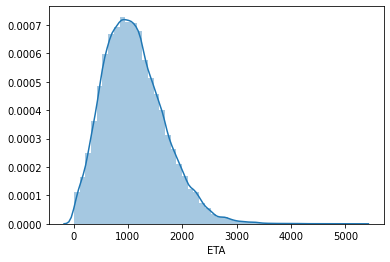

In [ ]:
target = cleaned[cleaned.test==False]["ETA"]
sns.distplot(target)
print("skewness : ",stats.skew(target.values))

we can see that the target ETA is positively skewed and don't follow a normal distribution , let's try the boxcox transform to fix that

<h2>Box-Cox transformation</h2>

Box-cox transform belongs to the family of power transformation techniques, which are useful to stabilize variance and make the data more gaussian-like distribution. Box-Cox transform are most common since it allows you to try various exponens and choose the best $\lambda$ value  instead of picking one manually.

$$
y_i^{(\lambda)} =
\begin{cases}
 \dfrac{y_i^\lambda - 1}{\lambda} & \text{if } \lambda \neq 0, \\
 \ln y_i & \text{if } \lambda = 0,
\end{cases}
$$

to know more about Transforming Variables techniques , read the following <a href="https://heartbeat.fritz.ai/hands-on-with-feature-engineering-techniques-transforming-variables-acea03472e24" >medium article</a>


In [ ]:
from sklearn.preprocessing import PowerTransformer
boxcox_transformer = PowerTransformer(method='box-cox', standardize=False)

skewness :  [-0.00496359]


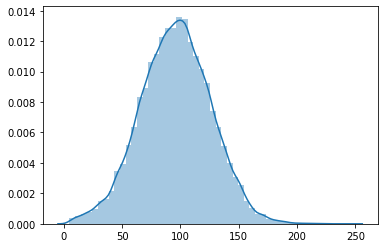

In [ ]:
target = cleaned[cleaned.test==False]["ETA"]

target=boxcox_transformer.fit_transform(target.values.reshape(-1,1))

sns.distplot(target)
print("skewness : ",stats.skew(target))

the curve now is way less skewed than the origin

# Training

In [ ]:
import math
#creating rmse adapted to our transformation
def rmse_boxcox(y_hat, data):

    y_true = data.get_label()
    y_true = boxcox_transformer.inverse_transform(y_true.reshape(-1,1))
    y_hat =  boxcox_transformer.inverse_transform(y_hat.reshape(-1,1))

    return 'rmse_boxcox', math.sqrt(metrics.mean_squared_error(y_true,y_hat)) , False

In [ ]:

drop_cols=["ETA",'Timestamp',"speed","date",'test']

In [ ]:
#running cross validation on our train set using Lightgbm

split = model_selection.TimeSeriesSplit(n_splits=5)

training = cleaned[cleaned.test==False]

X_train  = training.drop(drop_cols,axis=1)

Y_train = target.squeeze()

train_set=lgb.Dataset(X_train,Y_train)

params={"objective":"regression",
      'n_estimators':5000} 

eval_hist=lgb.cv(params=params,feval=rmse_boxcox,train_set=train_set,folds=split,
                 early_stopping_rounds=50,seed=SEED)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [ ]:
pd.DataFrame(eval_hist).tail()

,l2-mean,l2-stdv,rmse_boxcox-mean,rmse_boxcox-stdv
2859,40.743005,7.716742,129.249012,11.730222
2860,40.742467,7.717300,129.248433,11.730949
2861,40.742209,7.717224,129.249201,11.730250
2862,40.741468,7.717009,129.247910,11.730040
2863,40.741518,7.717638,129.247882,11.730862


from the table above , the index represent : num_tress - 1 , we will pick up that value since it performed well on our cv  
in our case , it's 2864

In [ ]:
#training our final model 
model=lgb.LGBMRegressor(n_estimators=2864,random_state=SEED)

model.fit(X_train,Y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=2864, n_jobs=-1, num_leaves=31, objective=None,
              random_state=70, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

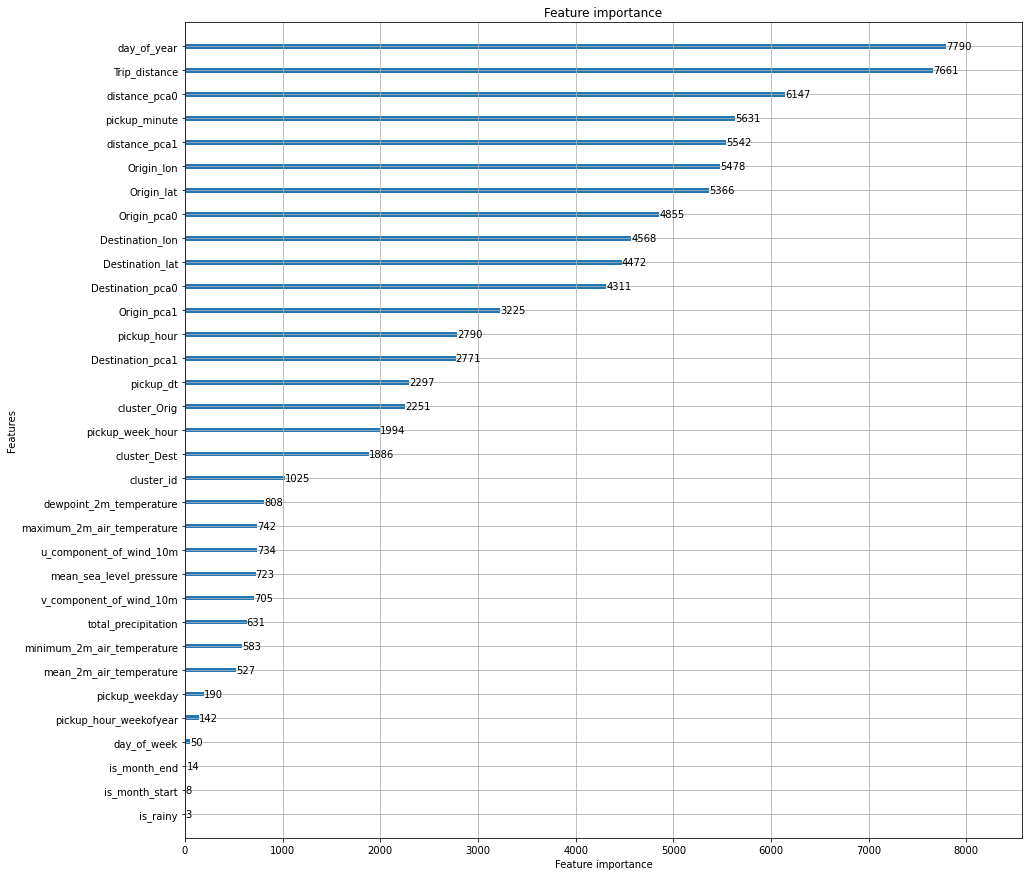

In [ ]:
lgb.plot_importance(model,figsize=(15,15))

# submission


In [ ]:
testing = cleaned[cleaned.test==True]

testing.drop(drop_cols,axis=1,inplace=True)

testing["ETA"]=boxcox_transformer.inverse_transform(model.predict(testing).reshape(-1,1))

testing[['ETA']].to_csv('submit.csv')

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# saving models (optional)

In [ ]:
import pickle
pkl_filename = "./drive/My Drive/kmean.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(kmean, file)

In [ ]:
pkl_filename = "./drive/My Drive/Minibatchkmean.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(minikmean, file)

In [ ]:
pkl_filename = "./drive/My Drive/pca.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(pca, file)

In [ ]:
pkl_filename = "./drive/My Drive/lgbRegressor.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)